In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV

from scipy import stats
from scipy.stats import skew, kurtosis

In [2]:
VER = 61            # VERSION NAME FOR SAVED MODEL FILES
SEED = 42           # TRAIN RANDOM SEED
FOLDS = 5           # FOLDS PER MODEL
project_dir = "../" # PROJECT FOLDER

## Logistic Regression Model

Due to the high-dimensional, low-sample size setting (HDLSS), it may be better to do a simpler logistic regression model. The XGBoost may be overfitting.

Since we're in HDLSS territory, regularization is important.

In [3]:
data_raw_path = "../data-raw"

train_features_csv = f"{data_raw_path}/train_features.csv"
train_outcomes_functional_csv = f"{data_raw_path}/train_outcomes_functional.csv"

test_features_csv = f"{data_raw_path}/test_features.csv"
test_outcomes_csv = f"{data_raw_path}/test_outcomes_Fun_template_update.csv"

metadata_csv = f"{data_raw_path}/metadata.csv"

In [4]:
train_features_df = pd.read_csv(train_features_csv)
train_outcomes_df = pd.read_csv(train_outcomes_functional_csv)

test_features_df = pd.read_csv(test_features_csv)
test_outcomes_df = pd.read_csv(test_outcomes_csv)

metadata_df = pd.read_csv(metadata_csv)

### One-hot encode Metadata

In [5]:
metadata_df.head()

,PID,bmi_category,age_category,sexcd,tx1_r,srdecc1,surgcd1,spcsuc1,scdecc1,hemccd1,mhpsyccd,mhneurcd,mhcardcd,mhmetacd
0,PID_0,Healthy,>65,2,D2,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0
1,PID_1,Healthy,<65,2,D1,0.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0
2,PID_2,Overweight,<65,1,P,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0
3,PID_3,Healthy,<65,2,D1,0.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0
4,PID_4,Healthy,<65,2,D2,NaN,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0


In [6]:
metadata_df.dtypes

PID              object
bmi_category     object
age_category     object
sexcd             int64
tx1_r            object
srdecc1         float64
surgcd1         float64
spcsuc1         float64
scdecc1         float64
hemccd1         float64
mhpsyccd        float64
mhneurcd        float64
mhcardcd        float64
mhmetacd        float64
dtype: object

In [7]:
metadata_df["sexcd"] = metadata_df["sexcd"].fillna(-999).astype(int)
metadata_df["srdecc1"] = metadata_df["srdecc1"].fillna(-999).astype(int)
metadata_df["surgcd1"] = metadata_df["surgcd1"].fillna(-999).astype(int)
metadata_df["spcsuc1"] = metadata_df["spcsuc1"].fillna(-999).astype(int)
metadata_df["scdecc1"] = metadata_df["scdecc1"].fillna(-999).astype(int)
metadata_df["hemccd1"] = metadata_df["hemccd1"].fillna(-999).astype(int)
metadata_df["mhpsyccd"] = metadata_df["mhpsyccd"].fillna(-999).astype(int)
metadata_df["mhneurcd"] = metadata_df["mhneurcd"].fillna(-999).astype(int)
metadata_df["mhcardcd"] = metadata_df["mhcardcd"].fillna(-999).astype(int)
metadata_df["mhmetacd"] = metadata_df["mhmetacd"].fillna(-999).astype(int)

In [8]:
metadata_df.head()
metadata_df.dtypes

PID             object
bmi_category    object
age_category    object
sexcd            int64
tx1_r           object
srdecc1          int64
surgcd1          int64
spcsuc1          int64
scdecc1          int64
hemccd1          int64
mhpsyccd         int64
mhneurcd         int64
mhcardcd         int64
mhmetacd         int64
dtype: object

In [9]:
metadata_df = metadata_df.astype(str)

In [10]:
metadata_df.dtypes

PID             object
bmi_category    object
age_category    object
sexcd           object
tx1_r           object
srdecc1         object
surgcd1         object
spcsuc1         object
scdecc1         object
hemccd1         object
mhpsyccd        object
mhneurcd        object
mhcardcd        object
mhmetacd        object
dtype: object

In [11]:
metadata_df = metadata_df.fillna("Missing")
metadata_df = metadata_df.replace("-999", "Missing")
metadata_df = metadata_df.replace("nan", "Missing")
metadata_df = metadata_df.replace(r">", "Over_", regex=True)
metadata_df = metadata_df.replace(r"<", "LessThan_", regex=True)

In [12]:
metadata_df.head()

,PID,bmi_category,age_category,sexcd,tx1_r,srdecc1,surgcd1,spcsuc1,scdecc1,hemccd1,mhpsyccd,mhneurcd,mhcardcd,mhmetacd
0,PID_0,Healthy,Over_65,2,D2,Missing,Missing,Missing,Missing,Missing,0,0,1,0
1,PID_1,Healthy,LessThan_65,2,D1,0,1,Missing,1,0,0,0,0,0
2,PID_2,Overweight,LessThan_65,1,P,0,0,Missing,0,Missing,0,0,0,0
3,PID_3,Healthy,LessThan_65,2,D1,0,1,Missing,1,0,0,0,0,0
4,PID_4,Healthy,LessThan_65,2,D2,Missing,1,0,Missing,0,0,0,0,0


In [13]:
metadata_df.groupby("bmi_category", dropna=False).size()

bmi_category
Healthy        391
Missing         19
Overweight     374
Underweight     13
dtype: int64

In [14]:
cols_to_encode = ["bmi_category", 
                  "age_category", 
                  "sexcd", 
                  "tx1_r", 
                  "srdecc1", 
                  "surgcd1", 
                  "spcsuc1", 
                  "scdecc1", 
                  "hemccd1", 
                  "mhpsyccd", 
                  "mhneurcd", 
                  "mhcardcd", 
                  "mhmetacd"]

In [15]:
metadata_df_encoded = pd.get_dummies(metadata_df, columns=cols_to_encode, dtype=int)

In [16]:
metadata_df_encoded.head()

,PID,bmi_category_Healthy,bmi_category_Missing,bmi_category_Overweight,bmi_category_Underweight,age_category_LessThan_65,age_category_Over_65,sexcd_1,sexcd_2,tx1_r_D1,...,mhpsyccd_Missing,mhneurcd_0,mhneurcd_1,mhneurcd_Missing,mhcardcd_0,mhcardcd_1,mhcardcd_Missing,mhmetacd_0,mhmetacd_1,mhmetacd_Missing
0,PID_0,1,0,0,0,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
1,PID_1,1,0,0,0,1,0,0,1,1,...,0,1,0,0,1,0,0,1,0,0
2,PID_2,0,0,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
3,PID_3,1,0,0,0,1,0,0,1,1,...,0,1,0,0,1,0,0,1,0,0
4,PID_4,1,0,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0


## One hot encode AIS from features

### Training dataset

In [17]:
ais_cols = ["ais1", "ais4", "ais8", "ais16"]
train_features_df[ais_cols] = train_features_df[ais_cols].fillna("Missing")
train_features_df[ais_cols] = train_features_df[ais_cols].replace(r" ", "_", regex=True)

In [18]:
train_features_df_encoded = pd.get_dummies(train_features_df, columns=ais_cols, dtype=int)

In [19]:
train_features_df_encoded.iloc[:,-15:].head() # Show last 15 columns

,ais4_AIS_D,ais4_AIS_E,ais4_Missing,ais8_AIS_A,ais8_AIS_B,ais8_AIS_C,ais8_AIS_D,ais8_AIS_E,ais8_ND,ais16_AIS_A,ais16_AIS_B,ais16_AIS_C,ais16_AIS_D,ais16_AIS_E,ais16_ND
0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


### Testing dataset

In [20]:
test_features_df.groupby("ais1", dropna=False).size()

ais1
AIS A    78
AIS B    13
AIS C    25
AIS D     6
dtype: int64

In [21]:
test_features_df["ais1"] = test_features_df["ais1"].fillna("Missing")
test_features_df["ais1"] = test_features_df["ais1"].replace(r" ", "_", regex=True)

In [22]:
test_features_encoded = pd.get_dummies(test_features_df, columns=["ais1"], dtype=int)

In [23]:
test_features_encoded.iloc[:,-15:].head()

,l1ppr01,l2ppr01,l3ppr01,l4ppr01,l5ppr01,s1ppr01,s2ppr01,s3ppr01,s45ppr01,vaccd01,anyana01,ais1_AIS_A,ais1_AIS_B,ais1_AIS_C,ais1_AIS_D
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0


## Merge datasets together

In [24]:
training_df = train_features_df_encoded.merge(train_outcomes_df, on="PID", how="inner")
full_training_df = training_df.merge(metadata_df_encoded, on="PID", how="inner")

testing_df = test_features_encoded.merge(test_outcomes_df, on="PID", how="inner")
full_testing_df = testing_df.merge(metadata_df_encoded, on="PID", how="inner")

In [25]:
full_training_df.head()

,PID,elbfll01,wrextl01,elbexl01,finfll01,finabl01,hipfll01,kneexl01,ankdol01,gretol01,...,mhpsyccd_Missing,mhneurcd_0,mhneurcd_1,mhneurcd_Missing,mhcardcd_0,mhcardcd_1,mhcardcd_Missing,mhmetacd_0,mhmetacd_1,mhmetacd_Missing
0,PID_62,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,1,0,0
1,PID_148,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,1,0,0
2,PID_508,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,1,0,0
3,PID_254,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,1,0,0
4,PID_189,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,1,0,0


In [27]:
full_testing_df.head()

,PID,elbfll01,wrextl01,elbexl01,finfll01,finabl01,hipfll01,kneexl01,ankdol01,gretol01,...,mhpsyccd_Missing,mhneurcd_0,mhneurcd_1,mhneurcd_Missing,mhcardcd_0,mhcardcd_1,mhcardcd_Missing,mhmetacd_0,mhmetacd_1,mhmetacd_Missing
0,PID_510,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,1,0,0
1,PID_448,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,1,0,0
2,PID_334,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,1,0,0
3,PID_581,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,1,0,0
4,PID_452,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,1,0,0


## Subsetting only Week 1 data

In [28]:
target_variables = ["PID", "modben", "elbfll01", "wrextl01", 
                    "elbexl01", "finfll01", "finabl01", "hipfll01", "kneexl01", "ankdol01", "gretol01", "ankpll01", 
                    "elbflr01", "wrextr01", "elbexr01", "finflr01", "finabr01", "hipflr01", "kneetr01", "ankdor01", 
                    "gretor01", "ankplr01", "c2ltl01", "c3ltl01", "c4ltl01", "c5ltl01", "c6ltl01", "c7ltl01", "c8ltl01", 
                    "t1ltl01", "t2ltl01", "t3ltl01", "t4ltl01", "t5ltl01", "t6ltl01", "t7ltl01", "t8ltl01", "t9ltl01", 
                    "t10ltl01", "t11ltl01", "t12ltl01", "l1ltl01", "l2ltl01", "l3ltl01", "l4ltl01", "l5ltl01", "s1ltl01", 
                    "s2ltl01", "s3ltl01", "s45ltl01", "c2ltr01", "c3ltr01", "c4ltr01", "c5ltr01", "c6ltr01", "c7ltr01", 
                    "c8ltr01", "t1ltr01", "t2ltr01", "t3ltr01", "t4ltr01", "t5ltr01", "t6ltr01", "t7ltr01", "t8ltr01", 
                    "t9ltr01", "t10ltr01", "t11ltr01", "t12ltr01", "l1ltr01", "l2ltr01", "l3ltr01", "l4ltr01", "l5ltr01", 
                    "s1ltr01", "s2ltr01", "s3ltr01", "s45ltr01", "c2ppl01", "c3ppl01", "c4ppl01", "c5ppl01", "c6ppl01", 
                    "c7ppl01", "c8ppl01", "t1ppl01", "t2ppl01", "t3ppl01", "t4ppl01", "t5ppl01", "t6ppl01", "t7ppl01", 
                    "t8ppl01", "t9ppl01", "t10ppl01", "t11ppl01", "t12ppl01", "l1ppl01", "l2ppl01", "l3ppl01", "l4ppl01", 
                    "l5ppl01", "s1ppl01", "s2ppl01", "s3ppl01", "s45ppl01", "c2ppr01", "c3ppr01", "c4ppr01", "c5ppr01", 
                    "c6ppr01", "c7ppr01", "c8ppr01", "t1ppr01", "t2ppr01", "t3ppr01", "t4ppr01", "t5ppr01", "t6ppr01", 
                    "t7ppr01", "t8ppr01", "t9ppr01", "t10ppr01", "t11ppr01", "t12ppr01", "l1ppr01", "l2ppr01", "l3ppr01", 
                    "l4ppr01", "l5ppr01", "s1ppr01", "s2ppr01", "s3ppr01", "s45ppr01"] + metadata_df_encoded.columns.tolist()

In [29]:
training_df = full_training_df[target_variables]
testing_df = full_testing_df[target_variables]

In [30]:
print(f"training_df.shape: {training_df.shape}")
print(f"testing_df.shape: {testing_df.shape}")

training_df.shape: (582, 174)
testing_df.shape: (118, 174)


### Removing any duplicated columns

i.e., `PID` is here twice

In [31]:
training_df = training_df.loc[:, ~training_df.columns.duplicated()]
testing_df = testing_df.loc[:, ~testing_df.columns.duplicated()]

In [32]:
print(f"training_df.shape: {training_df.shape}")
print(f"testing_df.shape: {testing_df.shape}")

training_df.shape: (582, 173)
testing_df.shape: (118, 173)


## Feature Engineering

In [ ]:
def process_and_feature_engineering(df):
    """
    Perform feature engineering by aggregating numerical and categorical features 
    over the 'PID' identifier. Numerical features are summarized using statistical 
    aggregations (mean, std, min, max, last, skewness, kurtosis, range, IQR, and trend),
    while categorical features are aggregated using count, last observed value, 
    and number of unique categories.

    Parameters
    ==========
    df (pd.DataFrame): Input DataFrame containing repeated measurements per patient, 
                       including a 'PID' column (identifier) and other numeric and 
                       categorical features.

    Returns
    =======
    pd.DataFrame: A patient-level DataFrame indexed by 'PID' with engineered features 
                  derived from numeric and categorical aggregation operations.
    """ 
    # All feature columns (excluding ID and target)
    exclude_cols = ["PID", "modben"]
    all_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Categorical features among remaining
    category_feats = df[all_cols].select_dtypes(include=["object", "category"]).columns.tolist()
    # Numeric features = all_cols - category_feats
    num_feats = [col for col in all_cols if col not in category_feats]

    # --- Aggregations ---

    # Basic numeric stats
    test_num_agg = df.groupby("PID")[num_feats].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    # Skewness and kurtosis
    test_num_skew = df.groupby("PID")[num_feats].apply(lambda x: x.skew()).rename(columns=lambda x: f"{x}_skew")
    test_num_kurt = df.groupby("PID")[num_feats].apply(lambda x: x.apply(kurtosis)).rename(columns=lambda x: f"{x}_kurt")
    test_num_skew_kurt = pd.concat([test_num_skew, test_num_kurt], axis=1)

    # Range
    test_num_range = df.groupby("PID")[num_feats].apply(lambda x: x.max() - x.min())
    test_num_range.columns = [f"{col}_range" for col in test_num_range.columns]

    # IQR
    test_num_iqr = df.groupby("PID")[num_feats].apply(lambda x: x.quantile(0.75) - x.quantile(0.25))
    test_num_iqr.columns = [f"{col}_iqr" for col in test_num_iqr.columns]

    # Trend
    def compute_trend(x):
        idx = np.arange(len(x))
        if len(x.dropna()) < 2:
            return np.nan
        return np.polyfit(idx, x.fillna(0), 1)[0]

    test_num_trend = df.groupby("PID")[num_feats].apply(lambda group: group.apply(compute_trend))
    test_num_trend.columns = [f"{col}_trend" for col in test_num_trend.columns]

    # Categorical aggregations -- we first check if there are any categorical values to aggregate
    if category_feats:
        test_cat_agg = df.groupby("PID")[category_feats].agg(['count', 'last', 'nunique'])
        test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    else:
        test_cat_agg = pd.DataFrame()

    # Combine everything
    df = pd.concat([
        test_num_agg,
        test_num_skew_kurt,
        test_num_range,
        test_num_iqr,
        test_num_trend,
        test_cat_agg
    ], axis=1)

    del test_num_agg, test_num_skew_kurt, test_num_range, test_num_iqr, test_num_trend, test_cat_agg
    print(f"Shape after engineering: {df.shape}")
    return df

In [33]:
# train = process_and_feature_engineering(training_df)
# test = process_and_feature_engineering(testing_df)

# What if we kept the original dataset
train = training_df
test = testing_df

print(f"Training shape: {train.shape}")
print(f"Testing shape: {test.shape}")

Training shape: (582, 173)
Testing shape: (118, 173)


In [35]:
train = train.sort_index().reset_index()
test = test.sort_index().reset_index()

## X and Y Datasets

In [39]:
# Ensure we have a category dtype
for col in train.select_dtypes(include='object').columns:
    train[col] = train[col].astype('category')

for col in test.select_dtypes(include='object').columns:
    test[col] = test[col].astype('category')

In [40]:
train = train[train['modben'] != 9.0].copy()
train['modben'] = train['modben'].astype(int) - 1
train.reset_index(drop=True, inplace=True)

In [41]:
x_train = train.drop("modben", axis=1)
y_train = train["modben"]

x_test = test.drop("modben", axis=1)
y_test = test["modben"]

In [42]:
if "PID" in x_train.columns:
    x_train = x_train.drop(columns=["PID"])

if "PID" in x_test.columns:
    pid_test = x_test["PID"].copy()
    x_test = x_test.drop(columns=["PID"])

## Utilities

In [43]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_curve, 
    auc, 
    precision_recall_curve
)
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(y_true, y_pred, title, project_dir, version):
    """
    Evaluate a model using various metrics and generate precision-recall and ROC curves.

    Parameters:
    - y_true (array-like): True labels.
    - y_pred (array-like): Predicted labels or class probabilities.
    - title (str): Title for the evaluation.
    - project_dir (str): Project directory.
    - version (int): Current model version.
    """
    try:
        if len(y_true) != len(y_pred):
            raise ValueError("Mismatched dimensions of y_true and y_pred.")

        accuracy = accuracy_score(y_true, y_pred)
        report = classification_report(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

        print(f"\n{title if title else 'Model Evaluation'}")
        print(f"Accuracy: {accuracy:.4f}")
        print("Confusion Matrix:\n", cm)
        print(f"Precision (weighted): {precision:.4f}")
        print(f"Recall (weighted):    {recall:.4f}")
        print(f"F1 Score (weighted):  {f1:.4f}")
        print("Classification Report:\n", report)

        # Optional: Precision-Recall and ROC curves
        # Only works for binary classification or if probabilities are provided for multiclass
        unique_classes = np.unique(y_true)
        if len(unique_classes) == 2:
            if hasattr(y_pred, "shape") and len(y_pred.shape) == 2 and y_pred.shape[1] > 1:
                y_pred_scores = y_pred[:, 1]
            else:
                y_pred_scores = y_pred  # Must be probabilities for PR/ROC

            pr_precision, pr_recall, _ = precision_recall_curve(y_true, y_pred_scores)
            plt.figure()
            plt.plot(pr_recall, pr_precision, color="darkorange", lw=2)
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title(f"{title}: Precision-Recall Curve")
            plt.savefig(f"{project_dir}/{title}_PRC-v{version}.png")

            fpr, tpr, _ = roc_curve(y_true, y_pred_scores)
            roc_auc = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"{title}: Receiver Operating Characteristic Curve")
            plt.legend(loc="lower right")
            plt.savefig(f"{project_dir}/{title}_ROC-v{version}.png")
        else:
            print("Skipping PR and ROC curve generation (requires binary classification).")

    except Exception as e:
        print(f"Error during model evaluation: {e}")
        raise

In [44]:
import joblib

def export_model(model, model_name, save_path):
    """
    Export the trained model for serving predictions.

    Parameters:
    - model (Model): Trained model.
    - model_name (str): Name of the model for logging purposes.
    - save_path (str): Path to save the exported model.
    """
    try:
        print(f"Saving model '{model_name}' to '{save_path}'")
        with open(save_path, "wb") as save_file:
            joblib.dump(model, save_file)
        print(f"Model '{model_name}' successfully saved to '{save_path}'")
    except Exception as e:
        print(f"Error during model export for '{model_name}': {e}")
        raise

## Train Logistic Regression

Using multiclass classification (`multi_class="multinomial"`)

In [45]:
def train_logistic_regression(x, y, version, cross_val=5, scoring="accuracy", n_jobs=-1, verbose=0, dir=project_dir):
    """
    Train a Logistic Regression model with cross-validation.

    Parameters
    ==========
    - x (pd.DataFrame): Input features.
    - y (pd.Series): Multiclass labels.
    - version (int): Current working version.
    - cross_val (int, optional): Number of CV folds. Default is 5.
    - scoring (str, optional): Scoring metric. Default is "accuracy".
    - n_jobs (int, optional): Parallel jobs for CV. Default is -1.
    - verbose (int, optional): Verbosity level.
    - dir (str, optional): Directory to save results.

    Returns
    =======
    - model (LogisticRegressionCV): Trained logistic regression model.
    """

    print(f"{cross_val}-fold cross-validation with Logistic Regression")
    print(f"Scoring strategy: {scoring}")
    print(f"Number of jobs to run in parallel: {n_jobs}")
    print(f"Verbosity: {verbose}")

    # Train logistic regression with CV
    model = LogisticRegressionCV(
        Cs=10,
        cv=cross_val,
        penalty="l2",
        solver="lbfgs",
        scoring=scoring,
        max_iter=5000,
        n_jobs=n_jobs,
        verbose=verbose
    )
    model.fit(x, y)
    print("Training completed.")

    # Save cross-validation scores
    try:
        cs_values = model.Cs_
        mean_scores = model.scores_[np.unique(y)[0]].mean(axis=0)
        results_df = pd.DataFrame({"C": cs_values, "MeanAccuracy": mean_scores})

        results_file = f"{dir}/data/logreg_cv_results-v{version}.csv"
        results_df.to_csv(results_file, index=False)
        print(f"Cross-validation results saved to: {results_file}")
    except Exception as e:
        print(f"Warning: could not save CV results — {e}")

    return model

In [46]:
def plot_logistic_coefficients(model, feature_names, save_path):
    coef = model.coef_
    avg_importance = np.abs(coef).mean(axis=0)
    top_idx = np.argsort(avg_importance)[-10:]
    
    top_features = np.array(feature_names)[top_idx]
    top_weights = avg_importance[top_idx]

    plt.barh(top_features, top_weights)
    plt.title("Top 10 Logistic Regression Coefficients (avg abs across classes)")
    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Top logistic regression coefficients plot saved to {save_path}")

In [47]:
def test_model(x, y, model, evaluate, project_dir, version):
    try:
        print("Making predictions...")
        predictions = model.predict(x)

        if evaluate:
            print("Evaluating model...")
            evaluate_model(y, predictions, title="Model Test", project_dir=project_dir, version=version)

        return model

    except Exception as e:
        print(f"Error during model testing: {e}")
        raise

### Actual Training

In [48]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [49]:
imputer = SimpleImputer(strategy="mean")
x_train_imputed = imputer.fit_transform(x_train)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_imputed)

In [50]:
logreg_model = train_logistic_regression(x_train_scaled, y_train, version=VER)

5-fold cross-validation with Logistic Regression
Scoring strategy: accuracy
Number of jobs to run in parallel: -1
Verbosity: 0
Training completed.
Cross-validation results saved to: ..//data/logreg_cv_results-v61.csv


Top logistic regression coefficients plot saved to ..//output/logreg_top10_features-v61.png


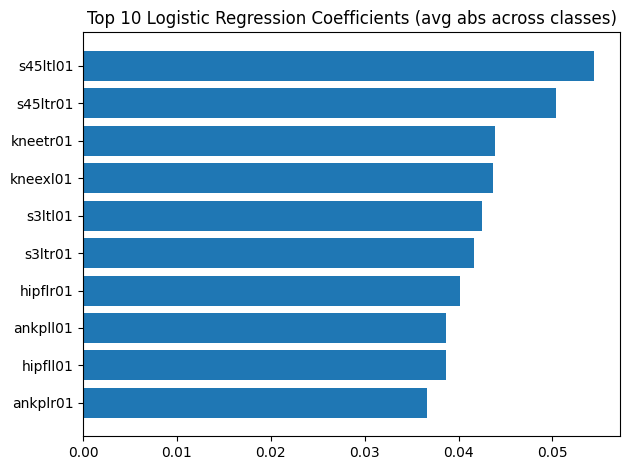

In [51]:
plot_logistic_coefficients(
    model=logreg_model,
    feature_names=x_train.columns,
    save_path=f"{project_dir}/output/logreg_top10_features-v{VER}.png"
)

In [52]:
export_model(model=logreg_model,
             model_name=f"Logistic_Regression_Model-V{VER}",
             save_path=f"{project_dir}/data/models/logistic_regression_model-v{VER}.joblib"
)

Saving model 'Logistic_Regression_Model-V61' to '..//data/models/logistic_regression_model-v61.joblib'
Model 'Logistic_Regression_Model-V61' successfully saved to '..//data/models/logistic_regression_model-v61.joblib'


## Predicting on new unseen data

In [53]:
x_test_imputed = imputer.transform(x_test)
x_test_scaled = scaler.transform(x_test_imputed)

In [54]:
predictions = logreg_model.predict(x_test_scaled)
probabilities = logreg_model.predict_proba(x_test_scaled)

In [55]:
result_df = pd.DataFrame(x_test_scaled, columns=x_test.columns)  # if x_test was originally a DataFrame
result_df["PID"] = pid_test
result_df["predicted_label"] = predictions
result_df["probability"] = probabilities.max(axis=1)

In [56]:
submission_df = result_df[["PID", "predicted_label"]].copy()
submission_df["predicted_label"] = submission_df["predicted_label"] + 1

In [57]:
submission_df = submission_df.rename(columns={"predicted_label":"modben"})

In [58]:
submission_df.head()

,PID,modben
0,PID_510,1
1,PID_448,1
2,PID_334,1
3,PID_581,1
4,PID_452,1


In [60]:
with open(f"../data/predicted_log_reg_v{VER}.csv", "wb") as input_csv:
    submission_df.sort_values(by='PID').to_csv(input_csv, index=False)